# Tuning and Developing Base Models
> Notebook for experimenting with new idea

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch import optim

from torch.nn import MSELoss, L1Loss
# Neural network implementations: fcNet, diffNet
from src.nnets import get_model, train_model, dense
from src import nnets
from src.utils import mse, lagged_xcorr

import matplotlib
plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,5)
# matplotlib.rcParams['font.size']= 22 # use for presentation


if torch.cuda.is_available():
    device = torch.device('cuda')
#     device = torch.device('cuda:3')
else:
    device = torch.device("cpu")
print(f'Available device: {device}')

Available device: cuda


In [4]:
from src import datautils

In [7]:
RTE_file_path = datautils.download_raw_from_RTE('real_time',return_filelist=True)
energy_2=datautils.read_RTE_as_kwh(RTE_file_path[0],convert2UTC=True)
energy_2

Downloading
"eCO2mix_RTE_Ile-de-France_En-cours-TR.zip" from
`https://eco2mix.rte-france.com/download/eco2mix/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip`

Extracting: datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls --> as "datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.xls"
- - - - - 
File Name                                             Modified             Size
eCO2mix_RTE_Ile-de-France_En-cours-TR.xls      2020-07-27 17:27:24       589324
- - - - - 
Deleting
datasets/eCO2mix_RTE_Ile-de-France_En-cours-TR.zip



,Energy(kWh)
Datetime,
2020-06-30 22:00:00,34250.0
2020-06-30 23:00:00,30750.0
2020-07-01 00:00:00,20000.0
2020-07-01 01:00:00,19500.0
2020-07-01 02:00:00,23250.0
...,...
2020-07-27 10:00:00,36750.0
2020-07-27 11:00:00,44250.0
2020-07-27 12:00:00,50750.0


In [5]:
import pandas as pd
from trader import trader_simulation

In [5]:
with open('persistence_T18.npy','rb') as f:
    persistence=np.load(f,allow_pickle=True).item()
lead_time = persistence['lead_time']
print('Persistence:',persistence)

Persistence: {'lead_time': 18, 'Persistence_Euclidean': 0.10196654967828511, 'Persistence_MSE': 0.20393309935657022, 'Persistence_MAE': 0.3105751548586914}


In [6]:
# Path for Datasets:
# all preprocessed data will be saved in `data_path`
data_path = os.path.relpath('../../../dataDIR/'+'preprocessed_linearinterp_avgmodels')
print(f'> Preprocessed data is from `{data_path}`\n')
# !ls $data_path

> Preprocessed data is from `../../../dataDIR/preprocessed_linearinterp_avgmodels`



In [7]:
pd.to_datetime('2020-07-28 23:00:00')+pd.Timedelta(hours=17)

Timestamp('2020-07-29 17:00:00')

In [8]:
pd.to_datetime('2020-07-28 23:00:00')+pd.Timedelta(hours=8)

Timestamp('2020-07-29 07:00:00')

In [20]:
pd.to_datetime('2020-07-28 20:00:00')-pd.Timedelta(hours=17)

Timestamp('2020-07-28 03:00:00')

In [21]:
pd.to_datetime('2020-07-28 03:00:00')+pd.Timedelta(hours=8)

Timestamp('2020-07-28 11:00:00')

## Dataset Notes

- Clock: for `YXdifwind40_speedclock` 
```python
# datasets:
train_fname = os.path.join(data_path,'train_preprocessed_YXdifwind40_speedclock.npy')
test_fname = os.path.join(data_path,'test_preprocessed_YXdifwind40_speedclock.npy')
```
```python
# best diffnet:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.5,.25,.15,.15,0]
output_dim = 1
```

- diff(Y,X) W=40, X(T+18),
```python
# Training data
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
```

- diff(Y, wind features) W=20,40,80, Wind features(T+18)
```python
window_size = 40
# Training data
train_fname = os.path.join(data_path,f'train_preprocessed_Ydiffwind_feature_w{window_size}.npy')
test_fname = os.path.join(data_path,f'test_preprocessed_Ydiffwind_feature_w{window_size}.npy')
```

## Base Model

Shapes
train: torch.Size([29371, 369]) torch.float32,
test: torch.Size([1546, 369]) torch.float32

Training x torch.Size([29371, 367]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 367]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])

epoch 0> train_loss: 0.20427870750427246, test_loss: 0.20267702639102936
epoch 25> train_loss: 0.07649775594472885, test_loss: 0.08589493483304977
epoch 50> train_loss: 0.05365438014268875, test_loss: 0.06817850470542908
epoch 75> train_loss: 0.04424541816115379, test_loss: 0.06180084869265556
epoch 100> train_loss: 0.03909020125865936, test_loss: 0.05788882449269295
epoch 125> train_loss: 0.03686654195189476, test_loss: 0.05730264261364937
epoch 150> train_loss: 0.03454309329390526, test_loss: 0.056432224810123444
epoch 175> train_loss: 0.03228596970438957, test_loss: 0.055801331996917725
epoch 200> train_loss: 0.029902558773756027, test_loss: 0.05510711669921875
epoch 225> train_loss: 0.02859828993678093, t

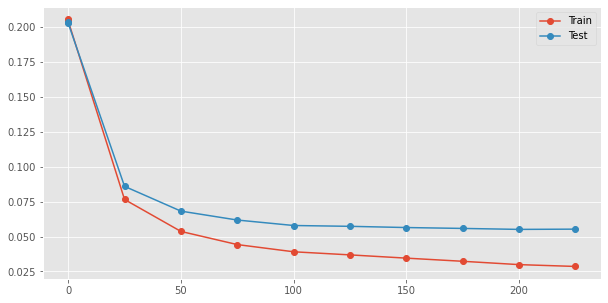

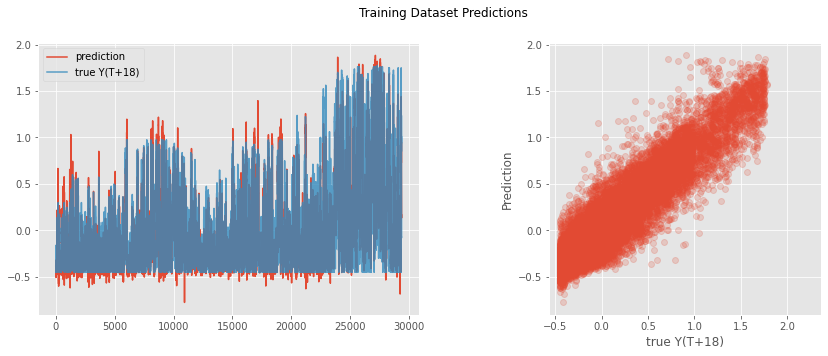

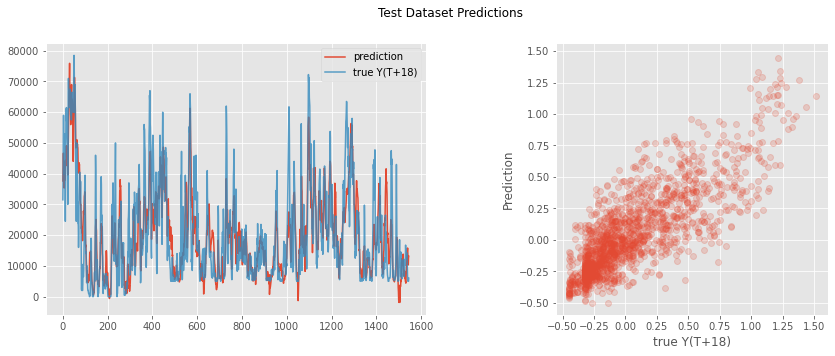

MSE loss (np): 0.05525653


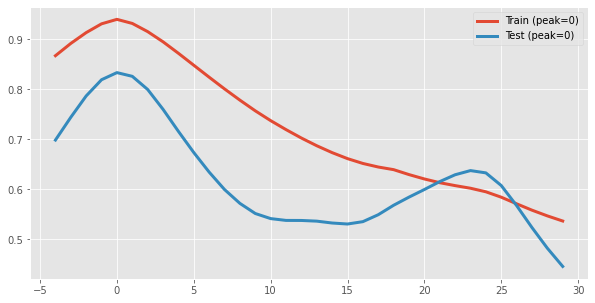

Train lag peak:0
Test lag peak:0
Net profit(euro cents):159358703.9453125
Profit: 159.4 millions


In [7]:
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+lead_time)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')


x_test = X_test[:,2:].to(device) # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+lead_time)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')


# Network size:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.5,.25,.15,.15,0]
output_dim = 1

# Training parameters
repeat = 1       # number of training runs per configuration
learning_rate = 0.001 # default for Adam
epochs = 250    # total number of training epochs == training iterations for the batch
loss_func = MSELoss(reduction='mean')
test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100



net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# scheduler = None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test*40000+18000,label='prediction')
axs[0].plot(target_test*40000+18000,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')


target_kwh = target_test.ravel()*40000+18000
y_pred_kwh = np.maximum(0,pred_test.ravel()*40000+18000)
profits= trader_simulation(range(y_pred_kwh.shape[0]),y_pred_kwh,target_kwh,print_at_end=True)
print(f'Profit: {profits/10**6:.1f} millions')

### Modified Loss Function 

Shapes
train: torch.Size([29371, 369]) torch.float32,
test: torch.Size([1546, 369]) torch.float32

Training x torch.Size([29371, 367]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 367]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])

epoch 0> train_loss: 0.14630615711212158, test_loss: 0.1534443348646164
epoch 20> train_loss: 0.09673520922660828, test_loss: 0.09917711466550827
epoch 40> train_loss: 0.0800132155418396, test_loss: 0.0905856117606163
epoch 60> train_loss: 0.06743911653757095, test_loss: 0.07979096472263336
epoch 80> train_loss: 0.061954397708177567, test_loss: 0.07582434266805649
epoch 100> train_loss: 0.05853903293609619, test_loss: 0.07500755041837692
epoch 120> train_loss: 0.056734878569841385, test_loss: 0.07436926662921906
epoch 140> train_loss: 0.055153604596853256, test_loss: 0.07370821386575699
epoch 160> train_loss: 0.053463734686374664, test_loss: 0.07317714393138885
epoch 180> train_loss: 0.05230211094021797, test

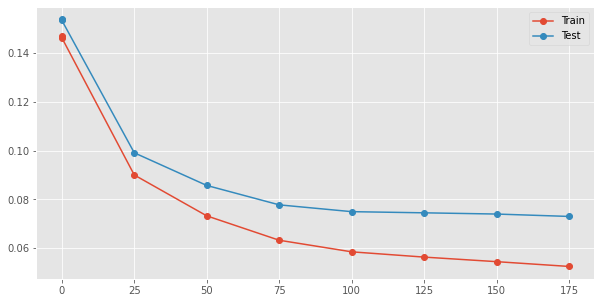

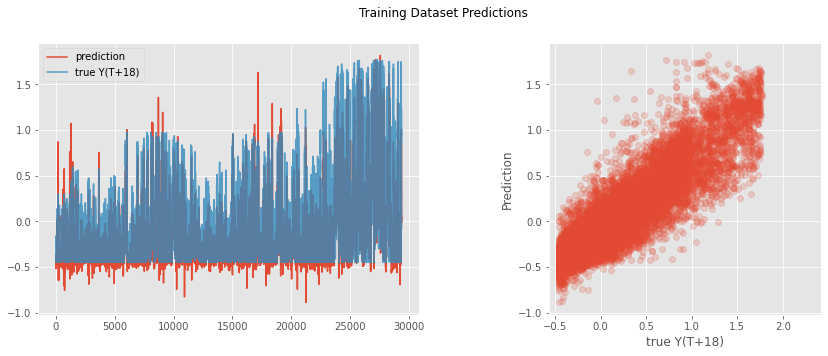

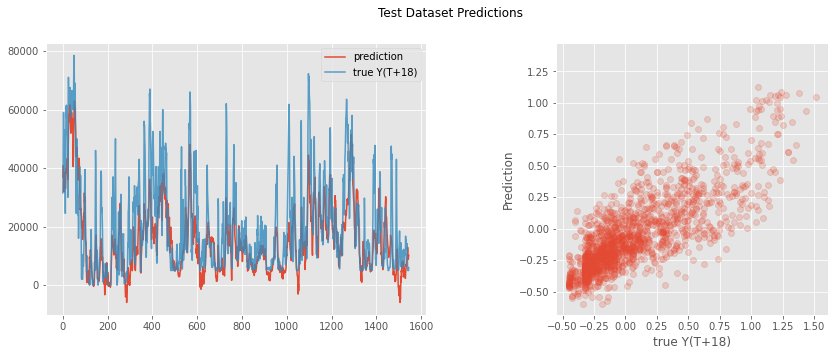

MSE loss (np): 0.073499486


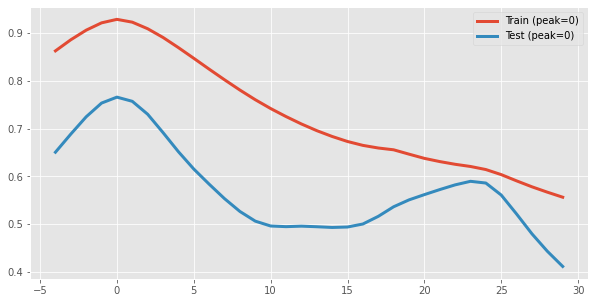

Train lag peak:0
Test lag peak:0
Net profit(euro cents):174894204.75585938
Profit: 174.9 millions


In [178]:
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+lead_time)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')


x_test = X_test[:,2:].to(device) # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+lead_time)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')


# Network size:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.3,.2,.2,.2,.1]
output_dim = 1

# Training parameters
repeat = 1       # number of training runs per configuration
learning_rate = 0.001 # default for Adam
epochs = 200    # total number of training epochs == training iterations for the batch
# loss_func = MSELoss(reduction='mean')
# v1:
# loss_func = lambda yp,yt: torch.mean(torch.clamp(yt-yp,min=0)/3+ 2*torch.clamp(yp-yt,min=0)/3)
# v2:
loss_func = lambda yp,yt: torch.mean(torch.clamp(yt-yp,min=0)/3.25+ 2.25*torch.clamp(yp-yt,min=0)/3.25)

test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100



net, opt = get_model('diffNet','Adam',
                     model_kwargs={'input_dim':input_dim,'layer_dims':layer_dims,'output_dim':output_dim,
                                  'dropout_p':dropout_p},
                    solver_kwargs={'lr':learning_rate},device=device)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# scheduler = None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test*40000+18000,label='prediction')
axs[0].plot(target_test*40000+18000,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')


target_kwh = target_test.ravel()*40000+18000
y_pred_kwh = np.maximum(0,pred_test.ravel()*40000+18000)
profits= trader_simulation(range(y_pred_kwh.shape[0]),y_pred_kwh,target_kwh,print_at_end=True)
print(f'Profit: {profits/10**6:.1f} millions')

In [114]:
# import ,os
# location of networks
# model_dir = os.path.relpath('./best_models')
# get all models that match the pattern:
# model_filenames = glob.glob(os.path.join(model_dir,'20Jul2020*'))
# model_filenames = ['best_models/24Jul2020_0150_ver1.pkl']

In [154]:
# import pickle, os, glob
# # location of networks
# file_name = os.path.join(os.path.relpath('./best_models'),'27Jul2020_1023_v5.pkl')
# # Save
# with open(file_name, 'wb') as f:
#     with torch.no_grad():
#         net.eval()
#         net.cpu()
#         pickle.dump(net, f)
#         net.to(device)

/mnt/mbi/home/murat/.local/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


### Wind speed vs energy relation

In [2]:
from src.nnets import dense, diffmlp_sq

Shapes
train: torch.Size([29371, 369]) torch.float32,
test: torch.Size([1546, 369]) torch.float32

Training x torch.Size([29371, 367]), Y0 torch.Size([29371, 1]), y torch.Size([29371, 1])

x_test torch.Size([1546, 367]), Y0_test torch.Size([1546, 1]), y_test torch.Size([1546, 1])

epoch 0> train_loss: 0.14333003759384155, test_loss: 0.15346704423427582
epoch 20> train_loss: 0.09352972358465195, test_loss: 0.1014583557844162
epoch 40> train_loss: 0.07588009536266327, test_loss: 0.089134581387043
epoch 60> train_loss: 0.06511736661195755, test_loss: 0.07770435512065887
epoch 80> train_loss: 0.06049462407827377, test_loss: 0.07423152029514313
epoch 100> train_loss: 0.056762538850307465, test_loss: 0.07280563563108444
epoch 120> train_loss: 0.054729659110307693, test_loss: 0.07238248735666275
epoch 140> train_loss: 0.05276394262909889, test_loss: 0.072062648832798
epoch 160> train_loss: 0.05118516832590103, test_loss: 0.07182353734970093
epoch 180> train_loss: 0.049859847873449326, test_lo

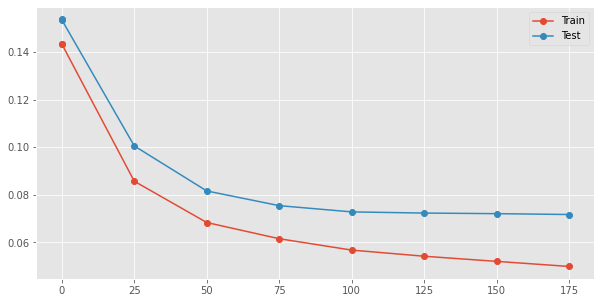

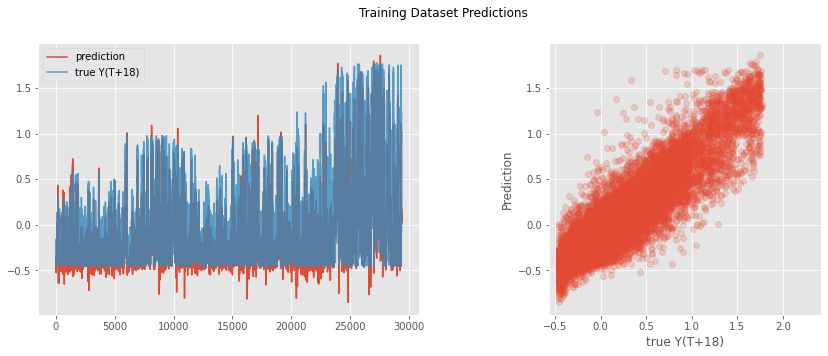

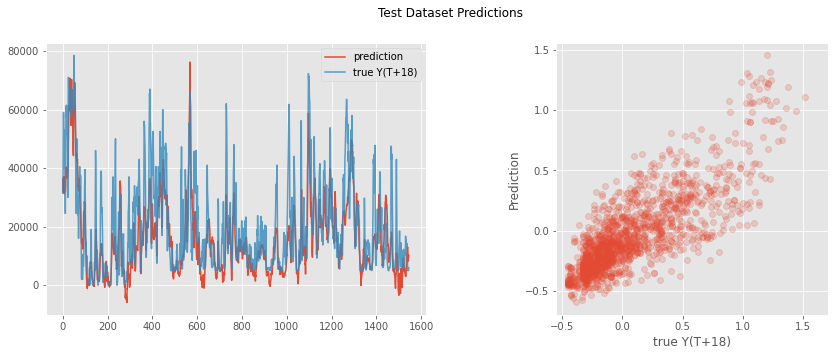

MSE loss (np): 0.067855224


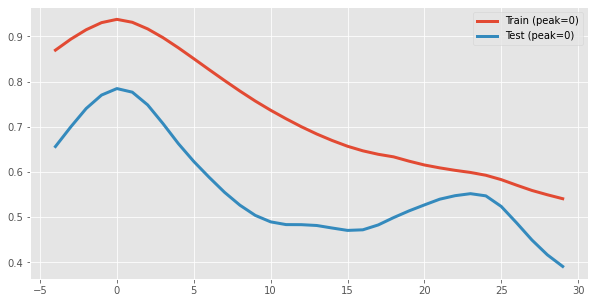

Train lag peak:0
Test lag peak:0
Net profit(euro cents):177870365.90820312
Profit: 177.9 millions


In [27]:
train_fname = os.path.join(data_path,'train_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')
test_fname = os.path.join(data_path,'test_preprocessed_Y18Y0dYwind40_X18X0dXwind40.npy')

with open(train_fname, 'rb') as f:
    X_train = torch.from_numpy(np.load(f).astype(np.float32))# Testing data
with open(test_fname, 'rb') as f:
    X_test = torch.from_numpy(np.load(f).astype(np.float32))
print('Shapes\ntrain: {} {},\ntest: {} {}\n'.format(X_train.shape, X_train.dtype,
                                                  X_test.shape, X_test.dtype))

x = X_train[:,2:].to(device) # X(T+18) for 8 loc-s
Y0 = X_train[:,1].reshape(-1,1).to(device) #Y(T+0)
y = X_train[:,:1].to(device) # Y(T+lead_time)
print(f'Training x {x.shape}, Y0 {Y0.shape}, y {y.shape}\n')


x_test = X_test[:,2:].to(device) # X(T+18) for 8 loc-s
Y0_test = X_test[:,1].reshape(-1,1).to(device) #Y(T+0)
y_test = X_test[:,:1].to(device) # Y(T+lead_time)

print(f'x_test {x_test.shape}, Y0_test {Y0_test.shape}, y_test {y_test.shape}\n')


# Network size:
input_dim = x.shape[1]
layer_dims = [512,128,64,64,32]
dropout_p = [.3,.2,.2,.15,.1]
output_dim = 1

# Training parameters
repeat = 1       # number of training runs per configuration
learning_rate = 0.001 # default for Adam
epochs = 200    # total number of training epochs == training iterations for the batch
# loss_func = MSELoss(reduction='mean')
# v1:
# loss_func = lambda yp,yt: torch.mean(torch.clamp(yt-yp,min=0)/3+ 2*torch.clamp(yp-yt,min=0)/3)
# v2:
loss_func = lambda yp,yt: torch.mean(torch.clamp(yt-yp,min=0)/3.25+ 2.25*torch.clamp(yp-yt,min=0)/3.25)

test_intervl =25 # collect loss every "test_intervl" iter-n
print_times=10   # number of times to print loss to the terminal

# Learning Rate policy:
step_size=100 # drop the learning rate every "step_size" iter-s
gamma= 0.599484 # drop the learning rate by a factor of 1/"gamma"
# autocaffe defaults for sg-temp--> gamma: 0.599484; step_size=100

net = diffmlp_sq(input_dim,out_dim=output_dim,layer_dims=layer_dims,dropout_p=dropout_p).to(device)

# opt = torch.optim.SGD(net.parameters(),lr=learning_rate, momentum=0.9)
opt = torch.optim.Adam(net.parameters(),lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=step_size, gamma=gamma) # lr scheduler
# scheduler = None
train_epochs, train_loss, test_loss = train_model(net,(x,Y0),y,
                                                  ((x_test,Y0_test), y_test),
                                                  opt, loss_func, epochs=epochs, 
                                                  scheduler=scheduler)

plt.plot(train_epochs,train_loss,'o-',label='Train')
plt.plot(train_epochs,test_loss,'o-',label='Test')
plt.legend();
plt.show()

# Training dataset results
net.eval()
pred = net(x,Y0).cpu().detach().numpy()
target = y.cpu().numpy()
# Test dataset
pred_test = net(x_test,Y0_test).detach().cpu().numpy()
target_test = y_test.cpu().numpy()


_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred,label='prediction')
axs[0].plot(target,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target,pred,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Training Dataset Predictions');
plt.show()

_,axs=plt.subplots(nrows=1,ncols=2,figsize=[15,5])
axs[0].plot(pred_test*40000+18000,label='prediction')
axs[0].plot(target_test*40000+18000,label=f'true Y(T+{lead_time})',alpha=.8)
axs[0].legend()
axs[1].plot(target_test,pred_test,'o',alpha=.2)
axs[1].set_xlabel(f'true Y(T+{lead_time})')
axs[1].set_ylabel('Prediction')
axs[1].axis('square')
plt.suptitle('Test Dataset Predictions');
plt.show()

# another way to calculate/re-calculate MSE loss for the model
mse_loss_with_np = mse(pred_test, target_test)# must be same as nn.MSELoss()'s result
print('MSE loss (np):',mse_loss_with_np)

# Lagged (Cross-) Correlation:
train_lags, train_xcorr = lagged_xcorr( pred.ravel(), target.ravel())
test_lags, test_xcorr   = lagged_xcorr( pred_test.ravel(), target_test.ravel())
lag_min = -5
lag_max = 30

train_mask = np.logical_and(train_lags>lag_min,train_lags<lag_max)
test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')


target_kwh = target_test.ravel()*40000+18000
y_pred_kwh = np.maximum(0,pred_test.ravel()*40000+18000)
profits= trader_simulation(range(y_pred_kwh.shape[0]),y_pred_kwh,target_kwh,print_at_end=True)
print(f'Profit: {profits/10**6:.1f} millions')

In [28]:
# import pickle, os, glob
# # location of networks
# file_name = os.path.join(os.path.relpath('./best_models'),'27Jul2020_1427_v1.pkl')
# # Save
# with open(file_name, 'wb') as f:
#     with torch.no_grad():
#         net.eval()
#         net.cpu()
#         pickle.dump(net, f)
#         net.to(device)

/mnt/mbi/home/murat/.local/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


## Load Past Models

In [30]:
import pickle,glob
from src.nnets import dense, diffmlp

model_filenames = glob.glob(os.path.join(os.path.relpath('./best_models'),'27Jul2020_14*'))
# model_filenames.extend(glob.glob(os.path.join(os.path.relpath('./best_models'),'25Jul2020_*'))[:2])

modellist = []
for fname in model_filenames:
    with open(fname, 'rb') as f:
        print(f'Loading {fname}')
        modellist.append(pickle.load(f))

for net in modellist:
    net.to(device)

def predictT18(x,y_0,nets=modellist):
    results = []
    y_0 = y_0.to(device)
    x = x.to(device)
    with torch.no_grad():
        for net in modellist:
            net.eval()
            #print(net(x,y_0).detach().cpu().numpy().shape)
            results.append(net(x,y_0).detach().cpu().numpy())
    
    return results

Loading best_models/27Jul2020_1427_v1.pkl
Loading best_models/27Jul2020_1427_v3.pkl
Loading best_models/27Jul2020_1427_v4.pkl
Loading best_models/27Jul2020_1427_v2.pkl
Loading best_models/27Jul2020_1427_v5.pkl


In [31]:
ypred_5 = predictT18(x_test,Y0_test)
ypred_5 = np.concatenate(ypred_5,axis=1)

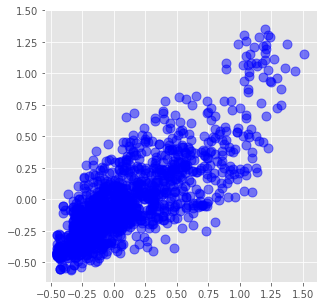

In [32]:
plt.plot(y_test.detach().cpu().numpy(),ypred_5.mean(axis=1,keepdims=True),'bo',ms=9,alpha=.5)
plt.axis('square');

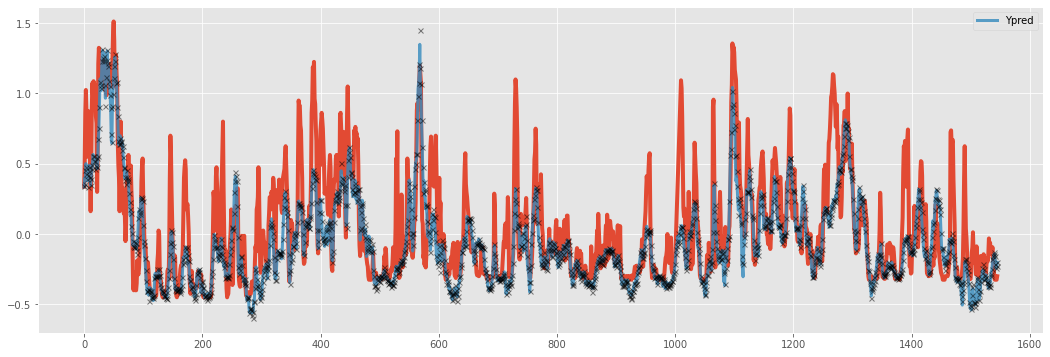

In [33]:
plt.figure(figsize=[18,6])
plt.plot(y_test.detach().cpu().numpy(),'-',lw=4)
plt.plot(ypred_5.mean(axis=1,keepdims=True),lw=3,alpha=.8,label='Ypred')
plt.plot(ypred_5[:,0],'kx',ms=5,alpha=.5)
plt.legend();


In [34]:
target_kwh = y_test.detach().cpu().numpy().ravel()*40000+18000
y_pred_kwh = np.maximum(0,ypred_5.mean(axis=1,keepdims=True).ravel()*40000+18000)
profits= trader_simulation(range(y_pred_kwh.shape[0]),y_pred_kwh,target_kwh,print_at_end=True)
print(f'Profit: {profits/10**6:.1f} millions')

Net profit(euro cents):178518601.34765625
Profit: 178.5 millions


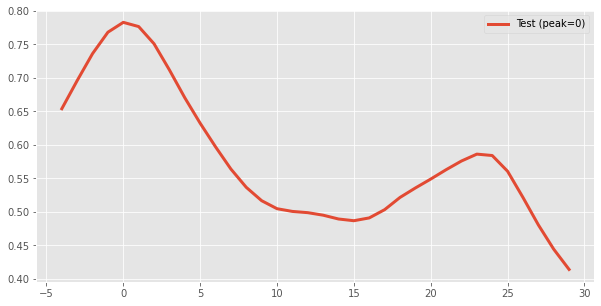

Test lag peak:0


In [169]:
# Lagged (Cross-) Correlation:
test_lags, test_xcorr   = lagged_xcorr( ypred_5.mean(axis=1,keepdims=True).ravel(), y_test.detach().cpu().numpy().ravel())
lag_min = -5
lag_max = 30

test_mask = np.logical_and(test_lags>lag_min,test_lags<lag_max)
# train_peak_lag = train_lags[train_mask][np.argmax(train_xcorr[train_mask])]
test_peak_lag = test_lags[test_mask][np.argmax(test_xcorr[test_mask])]

# plt.plot(train_lags[train_mask],train_xcorr[train_mask],label=f'Train (peak={train_peak_lag})',lw=3)
plt.plot(test_lags[test_mask],test_xcorr[test_mask],label=f'Test (peak={test_peak_lag})',lw=3)
plt.legend();
plt.show()
# print(f'Train lag peak:{train_peak_lag}')
print(f'Test lag peak:{test_peak_lag}')